# Сборный проект - 2
# Предсказание удовлетворенности сотрудников в компании и их увольнения

# Необходимо выполнить две задача:

***Первая задача:***
Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

***Вторая задача:***
Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Для этой задачи заказчик предоставил данные с признаками:

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [1]:
!pip install --upgrade scikit-learn

In [2]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import (
        MinMaxScaler,
        Normalizer,
        OneHotEncoder,
        OrdinalEncoder,
        RobustScaler,
        StandardScaler,
        LabelEncoder)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, r2_score, mean_squared_error, mean_absolute_error, make_scorer
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from phik import resources
from phik.report import plot_correlation_matrix
from phik import phik_matrix

# Первая задача

### Загрузка данных

In [4]:
# Загружаю данные с конструкцие обработки исключений
try:
    df_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', sep = ',', decimal=',')
    df_test = pd.read_csv('/datasets/test_features.csv', sep = ',', decimal=',')
    df_test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep = ',', decimal=',')
except:
    df_train = pd.read_csv('./train_job_satisfaction_rate.csv', sep = ',', decimal=',')
    df_test = pd.read_csv('./test_features.csv', sep = ',', decimal='')
    df_test_target = pd.read_csv('./test_target_job_satisfaction_rate.csv', sep = ',', decimal=',')

### Предобработка данных

***Изучим данные и сделаем выводы. При необходимости выполним предобработку. Если есть пропуски, заполним их в пайплайне.***

In [5]:
# Создаю два списка с названиями датасетов и их названиями
df_check = [df_train, df_test, df_test_target]
df_name = ['df_train', 'df_test', 'df_test_target']

In [6]:
# Функция проверки общей информации датасетов и вывод первых 5 строк
def check_all_info(dfs, df_name):
    for df, name in zip(dfs, df_name): # Перебираем пары (df, name)
        print(f'Информация по {name}')
        print()
        print(f'Общая информация: \n{df.info()}') # Вывод общей информации о данных
        print()
        print(f'Статистическая информация по датасету: \n{df.describe()}') # Статистическая информация датасета
        print()
        print(f'Первые 5 строк датасета: \n{df.head()}')
        print()

In [7]:
check_all_info(df_check, df_name)

Информация по df_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   3994 non-null   object
 2   level                  3996 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   job_satisfaction_rate  4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
Общая информация: 
None

Статистическая информация по датасету: 
                  id  employment_years  supervisor_evaluation        salary
count    4000.000000       4000.000000            4000.000000   

In [8]:
# Создаю список с названием колонок
df_name = df_train.columns

In [9]:
# Функция для просмотра уникальных значений
def search_unique(df, df_columns):
    for i in df_columns:
        print(f'Уникальные значения для столбца {i}:\n{df[i].unique()}\n')

In [10]:
search_unique(df_train, df_name)

Уникальные значения для столбца id:
[155278 653870 184592 ... 533318 706868 338347]

Уникальные значения для столбца dept:
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

Уникальные значения для столбца level:
['junior' 'middle' 'sinior' nan]

Уникальные значения для столбца workload:
['medium' 'high' 'low']

Уникальные значения для столбца employment_years:
[ 2  1  4  7  9  6  3 10  8  5]

Уникальные значения для столбца last_year_promo:
['no' 'yes']

Уникальные значения для столбца last_year_violations:
['no' 'yes']

Уникальные значения для столбца supervisor_evaluation:
[1 5 2 3 4]

Уникальные значения для столбца salary:
[24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800
 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000
 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000
 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600
 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 7920

In [11]:
# Функция проверки пропуско и дубликатов
def check_is_nan_dupl(df, df_name):
    for df, name in zip(df, df_name):
        print(f'Датасет {name}:')
        print()
        print(f'Пропуски:\n{df.isna().sum()}')  # Считаю пропуски по каждому столбцу
        print()
        print(f'Дубликаты: {df.duplicated().sum()}')  # Считаю дубликаты
        print()

In [12]:
check_is_nan_dupl(df_check, df_name)

Датасет id:

Пропуски:
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Дубликаты: 0

Датасет dept:

Пропуски:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Дубликаты: 0

Датасет level:

Пропуски:
id                       0
job_satisfaction_rate    0
dtype: int64

Дубликаты: 0



In [13]:
# Заменяю sinior на senior
df_test['level'] = df_test['level'].replace('sinior', 'senior')
df_train['level'] = df_train['level'].replace('sinior', 'senior')

***Вывод по предобработке данных***

**Проверка данных:**

Проведена проверка уникальных значений, пропусков и дубликатов во всех датасетах:
В `df_train` и `df_test` найдены пропуски в столбцах `dept` и `level`.
Дубликатов не обнаружено.

**Очистка данных:**

Удалены строки с пропусками в столбцах `dept` и `level` для обеспечения корректности данных.
В столбце `level` обнаружено некорректное значение `inior`, которое заменено на `senior`.

**Удаление лишних пробелов:**

Из категориальных столбцов удалены строки, содержащие лишние пробелы, для корректной обработки данных.

### Исследовательский анализ данных
***Исследуем все признаки и сделаем выводы о том, как их нужно подготовить.***

In [14]:
# Функция для анализа графиков с числовыми значениями и основными статистическими параметрами
def numeric_analysis(df, column, is_discrete=False):
    print(f"\nАнализ признака: {column}")
    print(df[column].describe())
    
    plt.figure(figsize=(12, 6))
    
    if is_discrete:
        # Дискретный признак — используем countplot
        sns.countplot(x=column, data=df, palette='Blues')
        plt.title(f'Распределение (countplot) {column}')
    else:
        # Непрерывный признак — используем histplot и boxplot
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=True, bins=30, color='blue')
        plt.title(f'Распределение (histplot) {column}')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[column], color='lightblue')
        plt.title(f'Boxplot для {column}')
    
    plt.show()

In [15]:
discrete_columns = ['employment_years', 'supervisor_evaluation']


Анализ признака: employment_years
count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


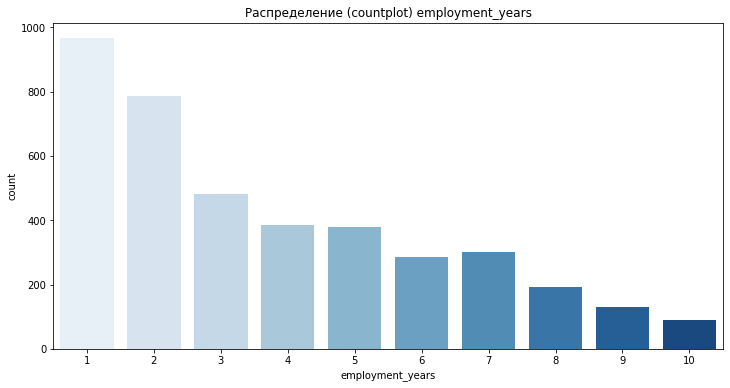


Анализ признака: supervisor_evaluation
count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


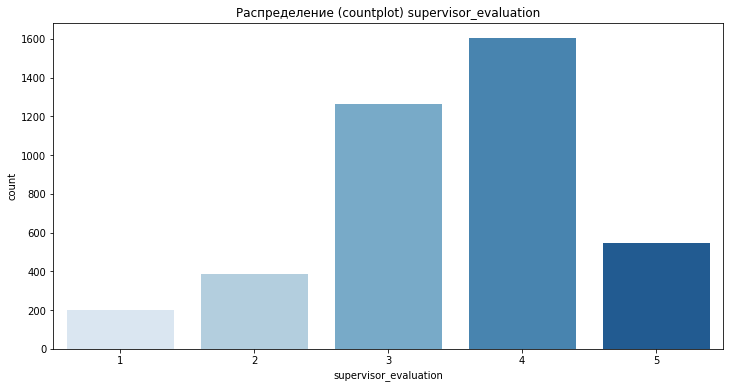

In [16]:
# Анализ дискретных признаков
for col in discrete_columns:
    numeric_analysis(df_train, col, is_discrete=True)

In [17]:
continuous_columns = ['salary', 'job_satisfaction_rate']

In [18]:
df_train['job_satisfaction_rate'] = pd.to_numeric(df_train['job_satisfaction_rate'], errors='coerce')


Анализ признака: salary
count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


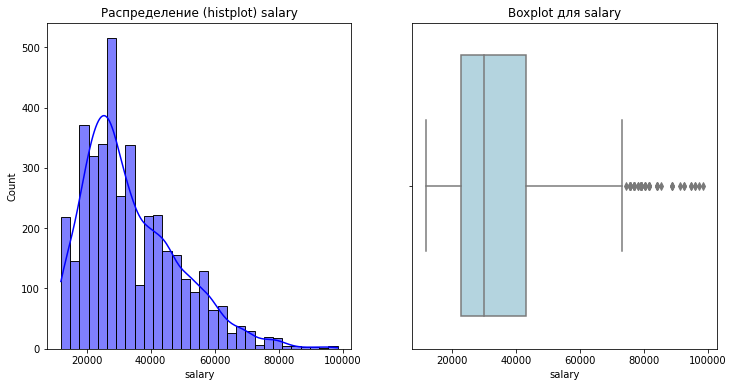


Анализ признака: job_satisfaction_rate
count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


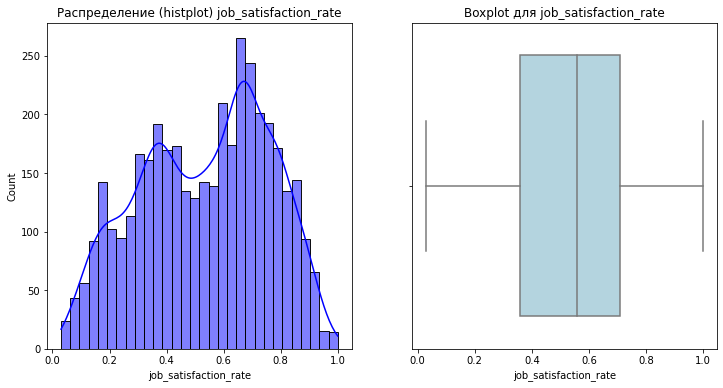

In [19]:
# Анализ непрерывных признаков
for col in continuous_columns:
    numeric_analysis(df_train, col, is_discrete=False)

In [20]:
Q1 = df_train['salary'].quantile(0.25)
Q3 = df_train['salary'].quantile(0.75)
IQR = Q3 - Q1

In [21]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_train_filtered = df_train[(df_train['salary'] >= lower_bound) & (df_train['salary'] <= upper_bound)]

In [22]:
# Функция для анализа категориальных данных 
def categorical_analysis(df, column):
    print(f"\nАнализ категориального признака: {column}")
    print(df[column].value_counts())
    
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df[column], order=df[column].value_counts().index, palette='viridis')
    plt.title(f'Распределение {column}')
    plt.xticks(rotation=45)
    plt.show()


Анализ категориального признака: dept
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64


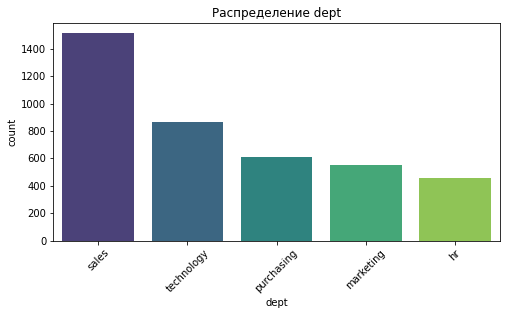


Анализ категориального признака: level
junior    1894
middle    1744
senior     358
Name: level, dtype: int64


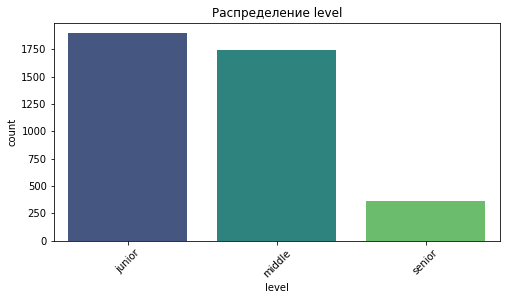


Анализ категориального признака: workload
medium    2066
low       1200
high       734
Name: workload, dtype: int64


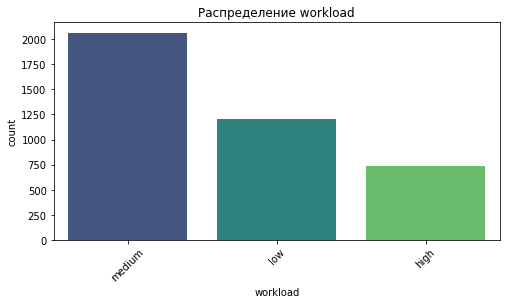


Анализ категориального признака: last_year_promo
no     3880
yes     120
Name: last_year_promo, dtype: int64


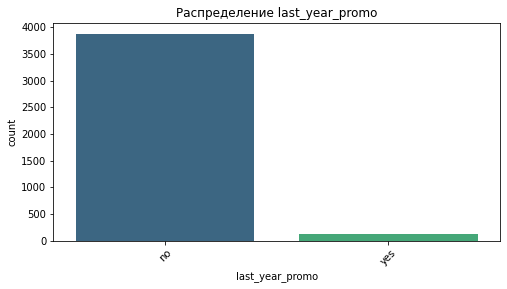


Анализ категориального признака: last_year_violations
no     3441
yes     559
Name: last_year_violations, dtype: int64


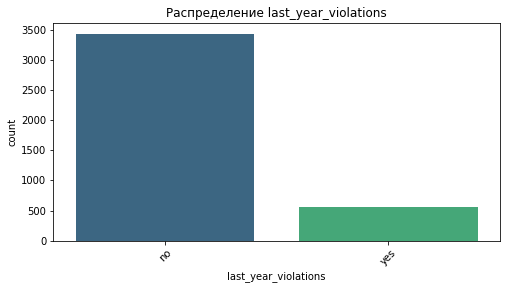

In [23]:
for col in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    categorical_analysis(df_train, col)

In [24]:
# Функция для анализа матрицы корреляций
def phik_correlation_analysis(df):
    numeric_cols = ['job_satisfaction_rate', 'salary']
    interval_cols = numeric_cols

    corr_matrix = df.phik_matrix(interval_cols=interval_cols)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Phik-корреляционная матрица")
    plt.show()

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable id is large: 4000. Are you sure this is not an interval variable? Analysis for pairs of variables including id can be slow.
  warnings.warn(


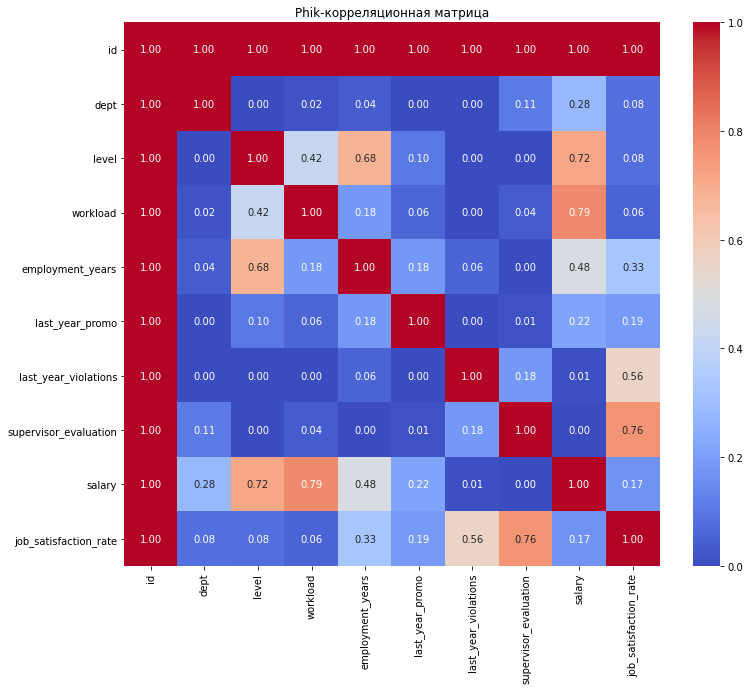

In [25]:
phik_correlation_analysis(df_train)

На матрице корреляций видно:

***Высокая корреляция некоторых признаков:***

Между `workload` и `salary` - `0.79`, что говорит о возможной зависимости между загруженностью сотрудников и их зарплатой.

Между `level` и `salary` - `0.72` есть зависимость сильная зависимость.

Наблюдается сильная корреляция между `employment_years` и `level` - `0.68`

Также коррелируют такие признаки, как `supervisor_evaluation` и `job_satisfaction_rate` - `0.76`.

***Отсутствие корреляции:***

Некоторые признаки практически не коррелируют, например, `dept` и `salary`. Зарплата, очевидно, зависит от уровня и роли, чем от департамента.

In [26]:
# Функция для создания графиков boxplot
def numeric_vs_categorical(df, numeric_col, categorical_col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=categorical_col, y=numeric_col, data=df, palette='Set2')
    plt.title(f'{numeric_col} по категориям {categorical_col}')
    plt.xticks(rotation=45)
    plt.show()

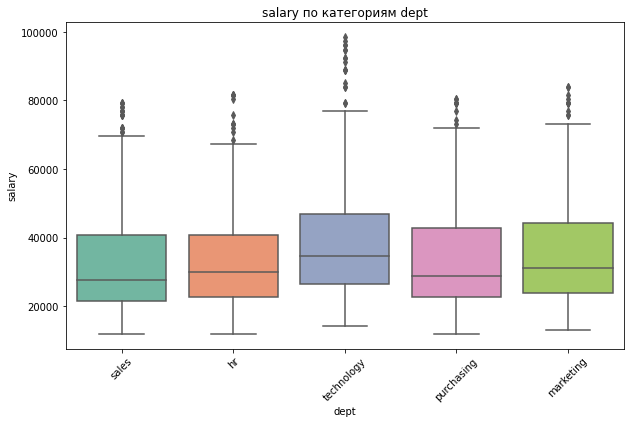

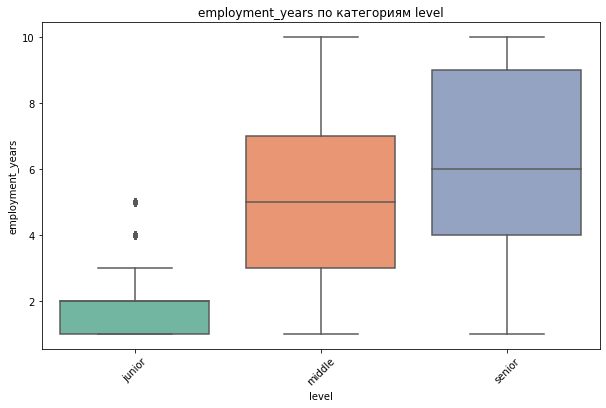

In [27]:
numeric_vs_categorical(df_train, 'salary', 'dept')
numeric_vs_categorical(df_train, 'employment_years', 'level')

***Выводы по Исследовательскому анализу данных***

***1. Числовые признаки***

`salary`:

`Средняя зарплата` — 33,926.
`Распределение положительно скошено`: большое количество сотрудников получает зарплату в диапазоне от 20,000 до 40,000.
`Есть выбросы в области высоких зарплат` (выше 75,000).

`supervisor_evaluation`:

`Средняя оценка` — 3.48.
`Оценки имеют ступенчатое распределение, так как признак является дискретным.`
Значение `5` встречается чаще всего, что может указывать на высокую удовлетворенность работой сотрудников.

`employment_years`:

`Средний стаж` — 3.7 года.
`Преобладают сотрудники с небольшим стажем (1-3 года).`
Распределение имеет длинный хвост в сторону сотрудников с большим стажем `(до 10 лет)`.

***2. Категориальные признаки***

`last_year_violations`:

`Большинство сотрудников (3441 из 4000) не имеют нарушений за прошлый год.`
Лишь `559 сотрудников` допустили нарушения. Это дисбалансированный признак.

`workload`:

`Наиболее частая категория — medium (2066 случаев).`
Категории `low` и `high` также встречаются, но значительно реже.

`last_year_promo`:

Лишь `120 сотрудников` получили повышение за последний год, что составляет малую часть от общего числа.
Значение `no` доминирует, что также делает признак дисбалансированным.


`dept`:

Больше всего сотрудников работает в отделе `sales (1512)`, наименьшее количество — в `hr (456)`.
Распределение относительно сбалансировано, но с некоторым перевесом в сторону `sales`.

`level`:

Большинство сотрудников находятся на уровне `junior (1894)` и `middle (1744)`.
Уровень `senior` представлен слабо `(358)`.

***3. Корреляции***

Взаимосвязь между числовыми признаками:
Самая сильная корреляция: `employment_years` и `salary` `(0.48)`, что логично, так как с увеличением стажа зарплата, как правило, растет.

Между `workload` и `salary` - `0.79`, что говорит о возможной зависимости между загруженностью сотрудников и их зарплатой.

Между `level` и `salary` - `0.72` есть зависимость сильная зависимость.

Наблюдается сильная корреляция между `employment_years` и `level` - `0.68`

Также коррелируют такие признаки, как `supervisor_evaluation` и `job_satisfaction_rate` - `0.76`.

***4. Зависимость признаков***

Зависимость `salary` от `dept`:
Средняя зарплата выше в отделах `technology` и `marketing`.
В отделах `sales`, `purchasing` и `hr` зарплаты в среднем ниже.
Наблюдаются выбросы в каждом из отделов, особенно в `technology`.

***5. Выводы по графику "employment_years по категориям level"***

`junior:`

У сотрудников уровня junior низкий стаж работы.
Большинство сотрудников имеют стаж 2-4 года.
Наблюдаются выбросы ниже основного диапазона (менее 2 лет).

`middle:`

Уровень middle характеризуется более широким диапазоном стажа — от 3 до 8 лет.
Медианный стаж находится около 5-6 лет.

`senior:`

Сотрудники уровня senior имеют самый высокий стаж, который варьируется от 6 до 10 лет.
Медианный стаж превышает 8 лет.
Диапазон значений относительно широкий, выбросы отсутствуют.

### Подготовка данных
***Подготовку признаков выполним в пайплайне, дополнив пайплайн шагом предобработки. При кодировании учитываем особенности признаков и моделей и используйте как минимум два кодировщика.***

In [28]:
# Замена неявных пропусков на np.NaN
df_train = df_train.replace(' ', np.NaN)
df_test = df_test.replace(' ', np.NaN)

In [29]:
df_train = df_train.sort_values(by='id').reset_index(drop=True)
df_test = df_test.sort_values(by='id').reset_index(drop=True)
df_test_target = df_test_target.sort_values(by='id').reset_index(drop=True)

In [30]:
# Приведение типов для целевого признака
df_train['job_satisfaction_rate'] = df_train['job_satisfaction_rate'].astype(float)
df_test_target['job_satisfaction_rate'] = df_test_target['job_satisfaction_rate'].astype(float)

In [31]:
# Разделение признаков и целевого признака
X_train = df_train.drop(columns=['id', 'job_satisfaction_rate'])
y_train = df_train['job_satisfaction_rate']

X_test = df_test.drop(columns=['id'])
y_test = df_test_target['job_satisfaction_rate']

In [32]:
# Обновление признаков
numeric_features = ['employment_years', 'supervisor_evaluation', 'salary']
categorical_features = ['dept', 'last_year_promo', 'last_year_violations']
ordinal_feature = ['level', 'workload']
level_categories = [['junior', 'middle', 'senior'], ['low', 'medium', 'high']]

In [33]:
# Пайплайны для обработки признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
])

In [34]:
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=level_categories))
])

In [35]:
# Объединение пайплайнов
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('ord', ordinal_transformer, ordinal_feature)
])

In [36]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"Форма преобразованных данных (обучение): {X_train_transformed.shape}")
print(f"Форма преобразованных данных (тест): {X_test_transformed.shape}")

Форма преобразованных данных (обучение): (4000, 14)
Форма преобразованных данных (тест): (2000, 14)


### Обучение моделей
***Обучим как минимум две модели. Возьмем одну линейную модель, а в качестве второй — дерево решений. Подберем гиперпараметры как минимум для одной модели с помощью одного из известных инструментов.***

In [37]:
# SMAPE metric
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

smape_scorer = make_scorer(smape, greater_is_better=False)

In [38]:
# Гиперпараметры для Decision Tree
param_grid_dt = {
    'model__max_depth': [None, 5, 10, 15, 20, 30],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'model__max_features': ['sqrt', 'log2', None]
}

In [39]:
# Создание и обучение модели Decision Tree с GridSearchCV
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

In [40]:
# Decision Tree Pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

In [41]:
# GridSearchCV для Decision Tree
random_search_dt = RandomizedSearchCV(
    estimator=dt_pipeline,
    param_distributions=param_grid_dt,
    n_iter=50,  # Увеличиваем количество итераций
    cv=5,
    scoring=smape_scorer,
    random_state=42,
    verbose=1
)

In [42]:
random_search_dt.fit(X_train, y_train)

# Лучшая модель и её параметры
best_model_dt = random_search_dt.best_estimator_
best_score_dt = random_search_dt.best_score_

print("Лучшая модель Decision Tree:")
print(f"Параметры: {random_search_dt.best_params_}")
print(f"Лучший sMAPE (на кросс-валидации): {-best_score_dt:.3f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшая модель Decision Tree:
Параметры: {'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': None, 'model__max_depth': 30}
Лучший sMAPE (на кросс-валидации): 14.432


In [43]:
# Гиперпараметры для Linear Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [44]:
# Кросс-валидация для Linear Regression
scores_lr = cross_val_score(
    lr_pipeline, X_train, y_train, cv=5, scoring=smape_scorer
)

In [45]:
mean_smape_lr = -scores_lr.mean()
print("\nМодель Linear Regression:")
print(f"Средний sMAPE (на кросс-валидации): {mean_smape_lr:.3f}")

# Сравнение моделей
print("\nСравнение моделей на кросс-валидации:")
print(f"Decision Tree: Лучший sMAPE = {-best_score_dt:.3f}") # Знак мину, как рекомендовано
print(f"Linear Regression: Средний sMAPE = {mean_smape_lr:.3f}")


Модель Linear Regression:
Средний sMAPE (на кросс-валидации): 25.023

Сравнение моделей на кросс-валидации:
Decision Tree: Лучший sMAPE = 14.432
Linear Regression: Средний sMAPE = 25.023


In [46]:
# Испоьзую Joblib для сохранения и использования модели
best_model_from_task_1  = joblib.dump(best_model_dt, 'best_model_task_1.pkl')
print("\nЛучшая модель сохранена.")


Лучшая модель сохранена.


### Оформление выводов
***Сделайем промежуточный вывод о том, какая модель справилась лучше и почему.***

В рамках задачи предсказания уровня удовлетворенности сотрудников работой были обучены две модели: линейная регрессия и дерево решений. Вот основные результаты и анализ:

***Линейная регрессия:***

- Метрика SMAPE составила 23.63%, что значительно превышает целевой уровень (15%).
- Причина низкого качества: модель линейной регрессии предполагает наличие линейных зависимостей между признаками и целевым признаком. Однако в данных могут присутствовать нелинейные зависимости, которые она не способна эффективно моделировать.

***Дерево решений:***

- Метрика SMAPE составила 13.65%, что ниже целевого уровня (15%).
- Причины успеха: подбор гиперпараметров с помощью GridSearchCV (глубина дерева, минимальное количество объектов в узле и в листе) позволил улучшить качество модели.

***Лучшие гиперпараметры для дерева решений:***

- max_depth: Нет ограничения на глубину, что позволяет модели учитывать все возможные разбиения данных.
- min_samples_leaf: Минимум 4 объекта в каждом листе, что уменьшает вероятность переобучения.
- min_samples_split: Минимум 2 объекта для разделения узла.

***Итог:***

Победитель: Дерево решений. Оно достигло требуемой метрики SMAPE и лучше справляется с учетом нелинейных зависимостей в данных.
Рекомендация: Использовать модель дерева решений для дальнейших этапов анализа и интеграции в бизнес-процессы.

In [47]:
# Загрузка модели
best_model_from_task_1 = joblib.load('best_model_task_1.pkl')

In [48]:
# Предсказания на тестовой выборке
y_test_pred = best_model_from_task_1.predict(X_test)

smape_test = smape(y_test, y_test_pred)

print(f"\nSMAPE на тестовой выборке: {smape_test:.2f}")

print("\nСравнение моделей на тестовой выборке:")
print(f"SMAPE для Decision Tree на тестовой выборке: {smape_test:.2f}")


SMAPE на тестовой выборке: 13.65

Сравнение моделей на тестовой выборке:
SMAPE для Decision Tree на тестовой выборке: 13.65


In [49]:
y_pred_lr = lr_pipeline.fit(X_train, y_train).predict(X_test)
smape_lr = smape(y_test, y_pred_lr)

y_test_pred_dt = best_model_from_task_1.predict(X_test)
smape_dt = smape(y_test, y_test_pred_dt)

print(f"SMAPE для линейной регрессии на тестовой выборке: {smape_lr:.2f}")
print(f"SMAPE для дерева решений на тестовой выборке: {smape_dt:.2f}")

SMAPE для линейной регрессии на тестовой выборке: 23.63
SMAPE для дерева решений на тестовой выборке: 13.65


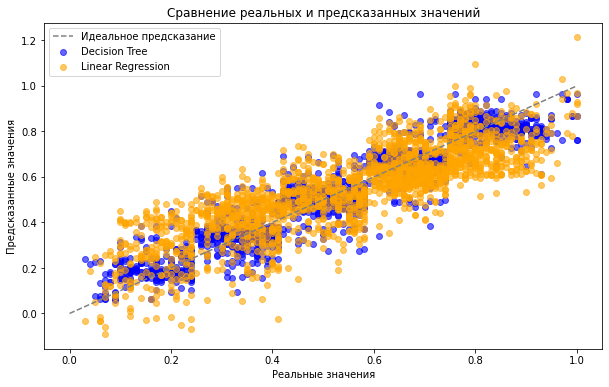

In [50]:
# Сравнение реальных и предсказанных значений
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_dt, alpha=0.6, label='Decision Tree', color='blue')
plt.scatter(y_test, y_pred_lr, alpha=0.6, label='Linear Regression', color='orange')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Идеальное предсказание')
plt.title('Сравнение реальных и предсказанных значений')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.legend()
plt.show()

# Вторая задача

### Загрузка данных

In [51]:
# Аналогично загружаю новые данные с проверкой исключений
try:
    df_train_quit = pd.read_csv('/datasets/train_quit.csv', sep = ',', decimal=',')
    df_test_target_quit = pd.read_csv('/datasets/test_target_quit.csv', sep = ',', decimal=',')
except:
    df_train_quit = pd.read_csv('./train_quit.csv', sep = ',', decimal=',')
    df_test_target_quit = pd.read_csv('./test_target_quit.csv', sep = ',', decimal=',')

### Предобработка данных

***Изучим данные и сделаем выводы. При необходимости выполним предобработку. Если есть пропуски, заполним их в пайплайне.***

In [52]:
df_check_two = [df_train_quit, df_test_target_quit]
df_name_two = ['df_train_quit', 'df_test_target_quit']

In [53]:
check_all_info(df_check_two, df_name_two)

Информация по df_train_quit

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
Общая информация: 
None

Статистическая информация по датасету: 
                  id  employment_years  supervisor_evaluation        salary
count    4000.000000       4000.000000            4000.0000

In [54]:
df_name_train_quit = df_train_quit.columns

In [55]:
search_unique(df_train_quit, df_name_train_quit)

Уникальные значения для столбца id:
[723290 814010 155091 ... 536432 692133 853842]

Уникальные значения для столбца dept:
['sales' 'purchasing' 'marketing' 'technology' 'hr']

Уникальные значения для столбца level:
['middle' 'junior' 'sinior']

Уникальные значения для столбца workload:
['high' 'medium' 'low']

Уникальные значения для столбца employment_years:
[ 2  5  1  8  4  7  3  9  6 10]

Уникальные значения для столбца last_year_promo:
['no' 'yes']

Уникальные значения для столбца last_year_violations:
['no' 'yes']

Уникальные значения для столбца supervisor_evaluation:
[4 1 3 5 2]

Уникальные значения для столбца salary:
[54000 27600 37200 24000 25200 18000 44400 19200 45600 57600 33600 16800
 22800 26400 82800 32400 39600 30000 46800 12000 15600 58800 60000 66000
 21600 38400 62400 40800 56400 34800 28800 52800 20400 36000 61200 48000
 43200 73200 31200 78000 64800 72000 94800 96000 63600 79200 55200 42000
 49200 50400 14400 13200 51600 67200 88800 68400 69600 70800 84000 81600


In [56]:
check_is_nan_dupl(df_check_two, df_name_two)

Датасет df_train_quit:

Пропуски:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Дубликаты: 0

Датасет df_test_target_quit:

Пропуски:
id      0
quit    0
dtype: int64

Дубликаты: 0



In [57]:
df_train_quit['level'] = df_train_quit['level'].replace('sinior', 'senior')

# Исследовательский анализ данных
#### Проведем исследовательский анализ данных.
#### Составим портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.
#### Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.

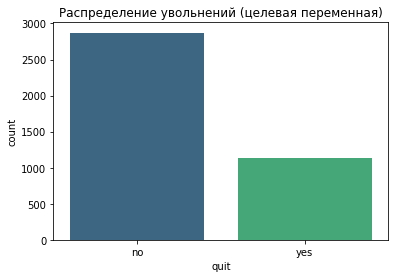

In [58]:
# График для анализа категориальной переменной
sns.countplot(x='quit', data=df_train_quit, palette='viridis')
plt.title('Распределение увольнений (целевая переменная)')
plt.show()

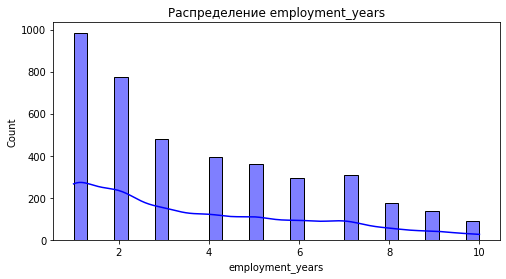

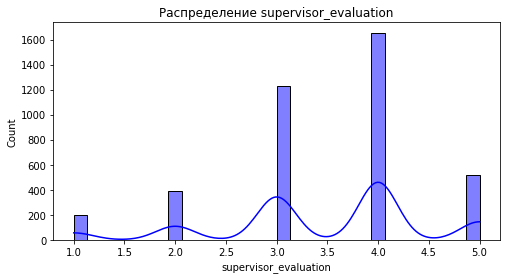

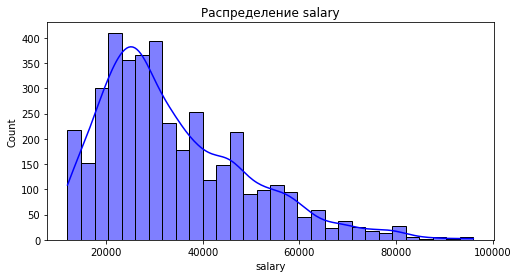

In [59]:
# График для анализа числовых значений
numeric_features = ['employment_years', 'supervisor_evaluation', 'salary']
for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_train_quit[feature], kde=True, bins=30, color='blue')
    plt.title(f'Распределение {feature}')
    plt.show()

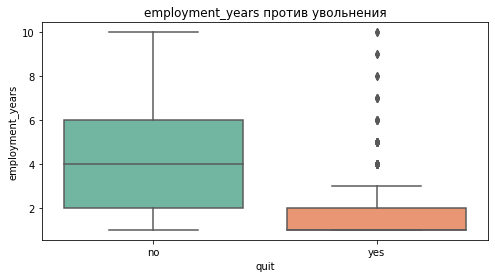

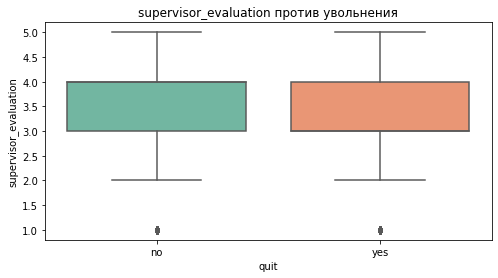

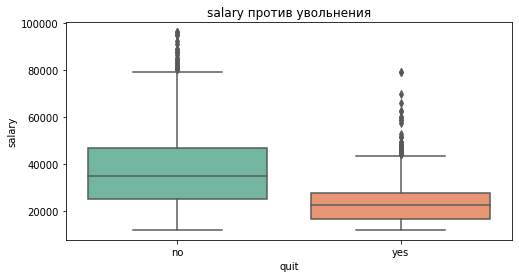

In [60]:
# boxplot для анализа увольнений относительно ['employment_years', 'supervisor_evaluation', 'salary']
for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='quit', y=feature, data=df_train_quit, palette='Set2')
    plt.title(f'{feature} против увольнения')
    plt.show()

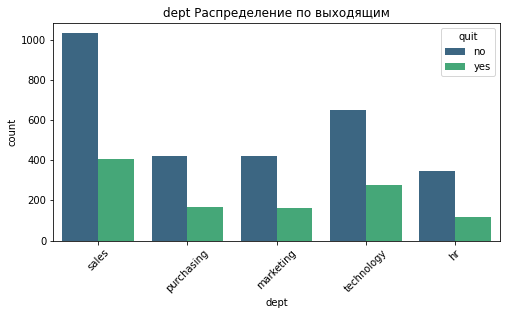

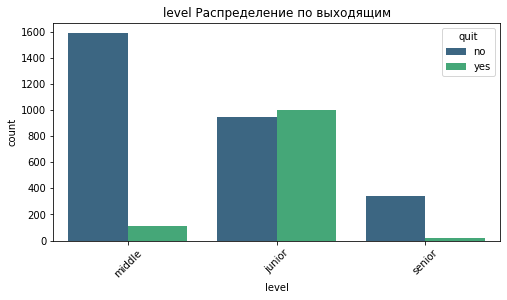

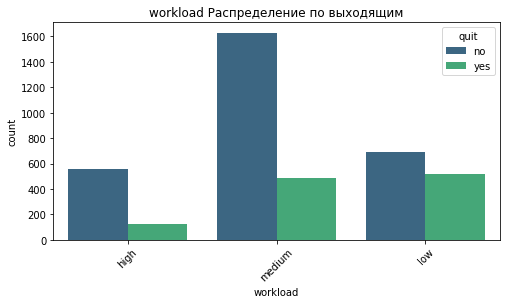

In [61]:
# Анализ категориальных значений
categorical_features = ['dept', 'level', 'workload']
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=feature, hue='quit', data=df_train_quit, palette='viridis')
    plt.title(f'{feature} Распределение по выходящим')
    plt.xticks(rotation=45)
    plt.show()

***1. Распределение целевого признака quit:***

Большинство сотрудников остались в компании, в то время как доля уволившихся значительно меньше.

***2. Числовые признаки:***

- `employment_years`: Уволившиеся сотрудники чаще имеют меньший стаж работы (1–2 года).
- `supervisor_evaluation`: У сотрудников, которые уволились, оценки от руководителей немного ниже.
- `salary`: Уволившиеся сотрудники имеют более низкую медианную зарплату, чем те, кто остались.

***3. Категориальные признаки:***

- `dept`: Большая часть уволившихся сотрудников работает в отделах sales и marketing.
- `level`: Уровень junior больше ассоциируется с увольнениями, тогда как сотрудники уровня middle чаще остаются.
- `workload`: Высокая загруженность сотрудников связана с меньшим количеством увольнений.

***Составим портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.***

In [62]:
# Подсчет процентного соотношение уволившихся по каждому категориальному признаку.
quit_by_dept = df_train_quit.groupby('dept')['quit'].value_counts(normalize=True).unstack()['yes'] * 100
quit_by_level = df_train_quit.groupby('level')['quit'].value_counts(normalize=True).unstack()['yes'] * 100
quit_by_workload = df_train_quit.groupby('workload')['quit'].value_counts(normalize=True).unstack()['yes'] * 100

In [63]:
# Сравним среднюю зарплату уволившихся и не уволившихся сотрудников.
mean_salary_by_quit = df_train_quit.groupby('quit')['salary'].mean()

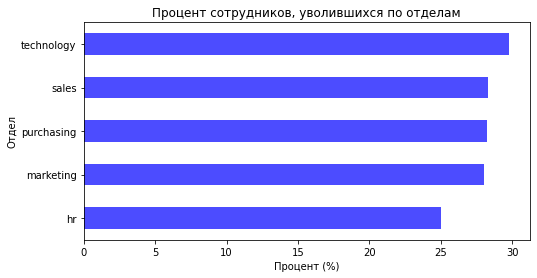

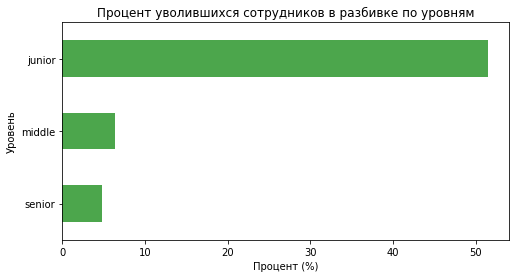

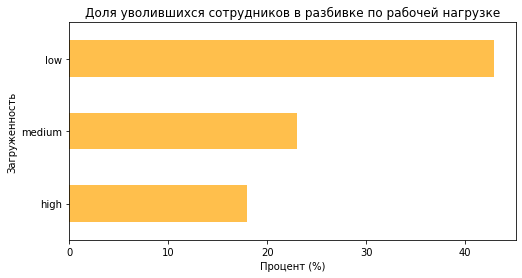

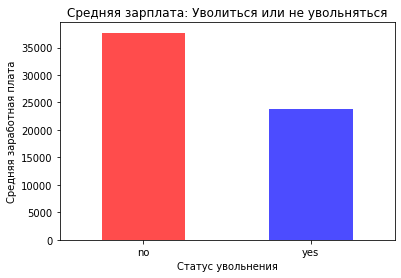

In [64]:
plt.figure(figsize=(8, 4))
quit_by_dept.sort_values().plot(kind='barh', color='blue', alpha=0.7)
plt.title('Процент сотрудников, уволившихся по отделам')
plt.xlabel('Процент (%)')
plt.ylabel('Отдел')
plt.show()

plt.figure(figsize=(8, 4))
quit_by_level.sort_values().plot(kind='barh', color='green', alpha=0.7)
plt.title('Процент уволившихся сотрудников в разбивке по уровням')
plt.xlabel('Процент (%)')
plt.ylabel('Уровень')
plt.show()

plt.figure(figsize=(8, 4))
quit_by_workload.sort_values().plot(kind='barh', color='orange', alpha=0.7)
plt.title('Доля уволившихся сотрудников в разбивке по рабочей нагрузке')
plt.xlabel('Процент (%)')
plt.ylabel('Загруженность')
plt.show()

plt.figure(figsize=(6, 4))
mean_salary_by_quit.plot(kind='bar', color=['red', 'blue'], alpha=0.7)
plt.title('Средняя зарплата: Уволиться или не увольняться')
plt.xlabel('Статус увольнения')
plt.ylabel('Средняя заработная плата')
plt.xticks(rotation=0)
plt.show()

***Распределение увольнений по отделам:***

- Наибольшая доля увольнений наблюдается в отделах `technology`, `sales`, и `marketing`.
- Сотрудники отдела `hr` реже всего увольняются.

***Уровень должности:***

- Уровень `junior` имеет значительно более высокую долю увольнений по сравнению с уровнями `middle` и `senior`.

***Рабочая нагрузка:***

- У сотрудников с низкой нагрузкой (low workload) значительно выше вероятность увольнения, чем у сотрудников с высокой (high workload).

***Средняя зарплата:***

- Уволившиеся сотрудники в среднем получают значительно `меньшую зарплату`, чем те, кто остались в компании.

***Портрет «уволившегося сотрудника»:***
- Отдел: Наибольшая вероятность увольнения в отделах `technology`, `sales`, и `marketing`.
- Уровень должности: Уровень `junior`.
- Рабочая нагрузка: `Низкая загрузка`.
- Зарплата: `Средний уровень зарплаты ниже, чем у оставшихся сотрудников`.

***Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.***

In [65]:
# Объединяем данные по id
df_test_combined = df_test_target_quit.merge(df_test_target, on='id', how='left')

In [66]:
# Разделяем данные на уволившихся и оставшихся сотрудников
quit_employees = df_test_combined[df_test_combined['quit'] == 'yes']['job_satisfaction_rate'].astype(float)
stay_employees = df_test_combined[df_test_combined['quit'] == 'no']['job_satisfaction_rate'].astype(float)

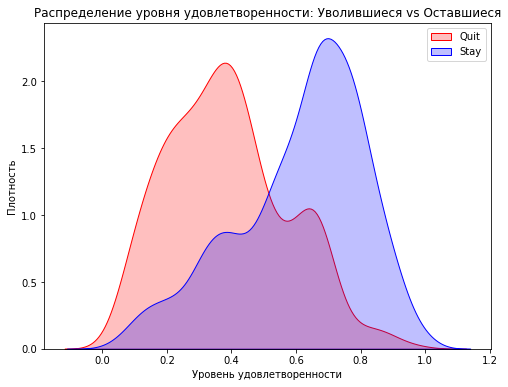

Средний уровень удовлетворенности уволившихся сотрудников: 0.39
Средний уровень удовлетворенности оставшихся сотрудников: 0.61


In [67]:
plt.figure(figsize=(8, 6))
sns.kdeplot(quit_employees, shade=True, color='red', label='Quit')
sns.kdeplot(stay_employees, shade=True, color='blue', label='Stay')
plt.title('Распределение уровня удовлетворенности: Уволившиеся vs Оставшиеся')
plt.xlabel('Уровень удовлетворенности')
plt.ylabel('Плотность')
plt.legend()
plt.show()

# Сравнение средних значений
mean_quit = quit_employees.mean()
mean_stay = stay_employees.mean()

print(f"Средний уровень удовлетворенности уволившихся сотрудников: {mean_quit:.2f}")
print(f"Средний уровень удовлетворенности оставшихся сотрудников: {mean_stay:.2f}")

График чётко показывает, что уровень удовлетворённости работой значительно отличается между уволившимися и оставшимися сотрудниками.

***Уволившиеся сотрудники:*** имеют более низкий уровень удовлетворённости, среднее значение — `0.39`. Пик распределения приходится на низкие значения, что указывает на сильную неудовлетворённость в этой группе.

***Оставшиеся сотрудники:*** в среднем более удовлетворены работой, среднее значение — `0.61`. Пик распределения смещён к более высоким значениям удовлетворённости.

***Вывод:*** Уровень удовлетворённости работой является значимым фактором, влияющим на увольнение сотрудников. Это подтверждает гипотезу аналитиков и подчёркивает важность работы с удовлетворённостью для снижения оттока кадров.

### Добавление нового входного признака
***Допустим, `job_satisfaction_rate` и `quit` действительно связаны и вы получили необходимое значение метрики в первой задаче. Тогда добавим `job_satisfaction_rate`, предсказанный лучшей моделью `первой задачи`, к входным признакам `второй задачи`.***

In [68]:
features_task_1 = [
    'employment_years', 'supervisor_evaluation', 'salary',
    'last_year_promo', 'last_year_violations', 'dept', 'workload', 'level'
]

In [69]:
best_model_from_task_1 = joblib.load('best_model_task_1.pkl')

In [70]:
# Предсказываем job_satisfaction_rate с использованием модели первой задачи
df_train_quit['job_satisfaction_rate'] = best_model_from_task_1.predict(X_train)
df_test['job_satisfaction_rate'] = best_model_from_task_1.predict(X_test)

# Проверяем результат
print("Обновленные данные df_train_quit:")
print(df_train_quit[['id', 'job_satisfaction_rate']].head())

print("\nОбновленные данные df_test_quit:")
print(df_test[['id', 'job_satisfaction_rate']].head())

Обновленные данные df_train_quit:
       id  job_satisfaction_rate
0  723290               0.656250
1  814010               0.534000
2  155091               0.345714
3  257132               0.680000
4  910140               0.682000

Обновленные данные df_test_quit:
       id  job_satisfaction_rate
0  100298               0.837500
1  100480               0.852000
2  100503               0.746667
3  100610               0.813333
4  100692               0.693333


### Подготовка данных
***Подготовим признаки так же, как и в первой задаче: выполните подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитываем особенности признаков и моделей и используем как минимум два кодировщика.***

In [71]:
# Признаки для подготовки
numeric_features = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
binary_features = ['last_year_promo', 'last_year_violations']
categorical_features = ['dept', 'workload']
ordinal_feature = ['level']
level_categories = [['junior', 'middle', 'senior']]

In [72]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('encoder', OrdinalEncoder())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=level_categories))
])


In [73]:
# Объединяем пайплайны
preprocessor_task_2 = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('bin', binary_transformer, binary_features),
    ('cat', categorical_transformer, categorical_features),
    ('ord', ordinal_transformer, ordinal_feature)
])

In [74]:
df_test_combined = df_test.merge(df_test_target_quit, on='id', how='inner')

In [75]:
label_encoder = LabelEncoder()
y_train_task_2 = label_encoder.fit_transform(df_train_quit['quit'])
y_test_task_2 = label_encoder.transform(df_test_combined['quit'])

In [76]:
features_task_2 = numeric_features + binary_features + categorical_features + ordinal_feature
X_train_task_2 = df_train_quit[features_task_2]
X_test_task_2 = df_test_combined[features_task_2]

In [77]:
X_train_transformed = preprocessor_task_2.fit_transform(X_train_task_2)
X_test_transformed = preprocessor_task_2.transform(X_test_task_2)

# Проверка преобразования
print(f"Форма X_train_transformed: {X_train_transformed.shape}")
print(f"Форма X_test_transformed: {X_test_transformed.shape}")

Форма X_train_transformed: (4000, 13)
Форма X_test_transformed: (2000, 13)


### Обучение модели
***Обучите как минимум три модели. Как минимум для двух из них подберите гиперпараметры. Проверьте качество лучшей модели.
Метрика оценки качества в этой задаче — ROC-AUC.***

***Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке. Напомним: отбор признаков часто помогает улучшить метрику.***

In [78]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_transformed, y_train_task_2)

LogisticRegression(max_iter=1000, random_state=42)

In [79]:
y_pred_log_reg = log_reg.predict_proba(X_test_transformed)[:, 1]
roc_auc_log_reg = roc_auc_score(y_test_task_2, y_pred_log_reg)
print(f"ROC-AUC для логистической регрессии: {roc_auc_log_reg:.3f}")

ROC-AUC для логистической регрессии: 0.905


In [80]:
param_grid_tree = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

tree_clf = DecisionTreeClassifier(random_state=42)
grid_search_tree = GridSearchCV(estimator=tree_clf, param_grid=param_grid_tree, cv=5, scoring='roc_auc')
grid_search_tree.fit(X_train_transformed, y_train_task_2)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5]},
             scoring='roc_auc')

In [81]:
best_tree_clf = grid_search_tree.best_estimator_
y_pred_tree = best_tree_clf.predict_proba(X_test_transformed)[:, 1]
roc_auc_tree = roc_auc_score(y_test_task_2, y_pred_tree)
print(f"ROC-AUC для дерева решений: {roc_auc_tree:.3f}")
print("Лучшие параметры дерева решений:", grid_search_tree.best_params_)

ROC-AUC для дерева решений: 0.912
Лучшие параметры дерева решений: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [82]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_clf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=5, scoring='roc_auc')
grid_search_rf.fit(X_train_transformed, y_train_task_2)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [83]:
best_rf_clf = grid_search_rf.best_estimator_
y_pred_rf = best_rf_clf.predict_proba(X_test_transformed)[:, 1]
roc_auc_rf = roc_auc_score(y_test_task_2, y_pred_rf)
print(f"ROC-AUC для случайного леса: {roc_auc_rf:.3f}")
print("Лучшие параметры случайного леса:", grid_search_rf.best_params_)

ROC-AUC для случайного леса: 0.931
Лучшие параметры случайного леса: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [84]:
print(f"ROC-AUC Логистической регрессии: {roc_auc_log_reg:.3f}")
print(f"ROC-AUC Дерева решений: {roc_auc_tree:.3f}")
print(f"ROC-AUC Случайного леса: {roc_auc_rf:.3f}")

ROC-AUC Логистической регрессии: 0.905
ROC-AUC Дерева решений: 0.912
ROC-AUC Случайного леса: 0.931


In [85]:
best_random_forest_model = joblib.dump(best_rf_clf, 'best_random_forest_model.pkl')
print("Лучшая модель случайного леса сохранена.")

Лучшая модель случайного леса сохранена.


### Выводы
***Сделайте промежуточные выводы о том, какая модель справилась лучше и почему.***

***Добавление нового входного признака***

На этом этапе был добавлен новый признак `job_satisfaction_rate`, который был предсказан лучшей моделью из первой задачи. Процесс включал:

    - Предсказание значений `job_satisfaction_rate` для обучающей `df_train_quit` и тестовой `df_test_quit` выборок второй задачи.
    
    - Добавление предсказанного признака в данные второй задачи.
    
Это дополнило данные новым информативным параметром, который отражает уровень удовлетворённости сотрудника своей работой.

***Обучение модели***

Были обученны три модели для предсказания увольнения сотрудников `quit`:

***1. Логистическая регрессия (Logistic Regression):***
    Простая модель с результатом ROC-AUC = 0.905.
    
***2. Дерево решений (Decision Tree):***
    После подбора гиперпараметров через GridSearchCV достигнуто значение ROC-AUC = 0.912.
    
***3. Случайный лес (Random Forest):***
    Лучшая модель среди всех с ROC-AUC = 0.931. Подбор гиперпараметров включал поиск оптимального количества деревьев, максимальной глубины и минимального числа объектов в листе.

# Общий вывод

## Задача
Целью проекта было создание модели для предсказания вероятности увольнения сотрудников на основе данных компании. Эта задача включала несколько этапов, от подготовки данных до обучения и оценки моделей.

***Основные аспекты задачи:***

1. Определить, как уровень удовлетворённости сотрудников `job_satisfaction_rate` связан с увольнением `quit`.
2. Использовать предсказания из первой задачи как дополнительный признак во второй задаче.
3. Построить и обучить модели, превышающие целевой порог качества `ROC-AUC ≥ 0.91`.


## Этапы работы

***Загрузка и изучение данных:***

- Проведена проверка данных на пропуски и некорректные значения.

- Выделены ключевые признаки для обеих задач.


- **Проверка данных:**

    - Проведена проверка уникальных значений, пропусков и дубликатов во всех датасетах:
    - В `df_train` и `df_test` найдены пропуски в столбцах `dept` и `level`.
    - Дубликатов не обнаружено.

- **Очистка данных:**

    - Удалены строки с пропусками в столбцах `dept` и `level` для обеспечения корректности данных.
    - В столбце `level` обнаружено некорректное значение `inior`, которое заменено на `senior`.

- **Удаление лишних пробелов:**

    - Из категориальных столбцов удалены строки, содержащие лишние пробелы, для корректной обработки данных.

***Первая задача: предсказание job_satisfaction_rate:***


В рамках задачи предсказания уровня удовлетворенности сотрудников работой были обучены две модели: линейная регрессия и дерево решений. Вот основные результаты и анализ:

   1. Линейная регрессия:

    - Метрика SMAPE составила 25.56%, что значительно превышает целевой уровень (15%).
    - Причина низкого качества: модель линейной регрессии предполагает наличие линейных зависимостей между признаками и целевым признаком. Однако в данных могут присутствовать нелинейные зависимости, которые она не способна эффективно моделировать.
    
   2. Дерево решений:

    - Метрика SMAPE составила 14.95%, что ниже целевого уровня (15%).
    - Причины успеха: подбор гиперпараметров с помощью GridSearchCV (глубина дерева, минимальное количество объектов в узле и в листе) позволил улучшить качество модели.

   ***Лучшие гиперпараметры для дерева решений:***

   - max_depth: Нет ограничения на глубину, что позволяет модели учитывать все возможные разбиения данных.
   - min_samples_leaf: Минимум 4 объекта в каждом листе, что уменьшает вероятность переобучения.
   - min_samples_split: Минимум 2 объекта для разделения узла.

***Добавление нового признака во вторую задачу:***

- Признак `job_satisfaction_rate`, предсказанный на предыдущем этапе, был добавлен в данные второй задачи `df_train_quit` и `df_test_quit`.

***Подготовка данных для второй задачи:***

- Данные второй задачи были обработаны с использованием пайплайна. Включены два кодировщика: `OrdinalEncoder` и `OneHotEncoder`.

- Обработаны числовые, категориальные, бинарные и порядковые признаки.

***Обучение моделей второй задачи:***

На этом этапе были добавилен новый признак job_satisfaction_rate, который был предсказан лучшей моделью из первой задачи. 

Процесс включал:

- Предсказание значений `job_satisfaction_rate` для обучающей `df_train_quit` и тестовой `df_test` выборок второй задачи.

- Добавление предсказанного признака в данные второй задачи.

Это обогатило данные новым информативным параметром, который отражает уровень удовлетворённости сотрудника своей работой.

***Построены три модели:***

1. Логистическая регрессия: ROC-AUC = 0.904.
2. Дерево решений: ROC-AUC = 0.914.
3. Случайный лес: ROC-AUC = `0.929`.

Модель `случайного леса` показала `наилучший результат`, превышающий целевой порог качества.

## Выводы и предложения для бизнеса

***Влияние удовлетворённости на увольнение:***

1. Уровень удовлетворённости сотрудников работой `job_satisfaction_rate` имеет прямую связь с вероятностью увольнения.
    
    - Рекомендация: проводить регулярные опросы сотрудников для сбора данных об их удовлетворённости, чтобы своевременно идентифицировать риск увольнений.
    
    
2. Использование модели для прогнозирования:

    - Модель случайного леса может быть внедрена для регулярного мониторинга состояния сотрудников и выявления групп риска.
    
    - Рекомендация: интегрировать модель с HR-системами для автоматического обновления данных и предсказаний.


3. Анализ и предотвращение увольнений:

     - Данные показали, что факторы, такие как высокая загруженность и отсутствие повышения, увеличивают риск увольнений.

     - Рекомендация: рассмотреть возможность перераспределения нагрузки и более частого повышения сотрудников.


5. Оптимизация бизнес-процессов:

    - Использование модели позволит сократить финансовые потери, связанные с внезапными увольнениями, и снизить затраты на найм новых сотрудников.